In [1]:
from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

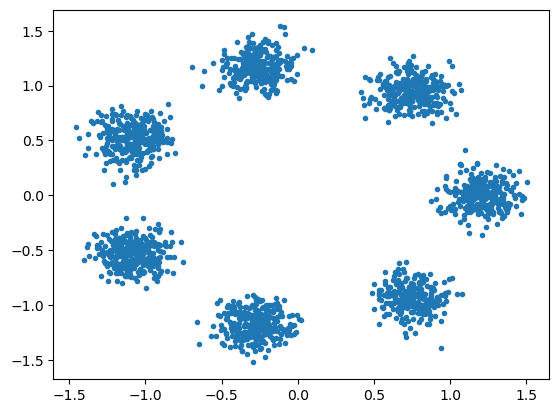

In [3]:
def generate_pinwheel(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb
    D = 2 # dimensionality
    K = 3 # number of classes
    N = num // K  # note: we will not generate exactly num datapoints unless K divides num
    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + rng.standard_normal(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    return X

X = generate_pinwheel(num=2000, rng=rng)
plt.plot(X[:, 0], X[:, 1], '.')

In [4]:
Activation = Callable[[jax.Array], jax.Array]


class EnergyModel(nn.Module):
    features: Sequence[int]
    activation: Activation = nn.relu

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        energy = nn.Dense(1)(x) 
        return energy 

model = EnergyModel(features=[64, 64, 64])
print(model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                              EnergyModel Summary                              
┌─────────┬─────────────┬───────────────┬───────────────┬─────────────────────┐
│ path    │ module      │ inputs        │ outputs       │ params              │
├─────────┼─────────────┼───────────────┼───────────────┼─────────────────────┤
│         │ EnergyModel │ float32[1,2]  │ float32[1,1]  │                     │
├─────────┼─────────────┼───────────────┼───────────────┼─────────────────────┤
│ Dense_0 │ Dense       │ float32[1,2]  │ float32[1,64] │ bias: float32[64]   │
│         │             │               │               │ kernel:             │
│         │             │               │               │ float32[2,64]       │
│         │             │               │               │                     │
│         │             │               │               │ 192 (768 B)         │
├─────────┼─────────────┼───────────────┼───────────────┼─────────────────────┤
│ Dense_1 │ Dense       │ float32[1,64]

In [5]:
def EBMloss(param,data,sample):
    pos = model.apply(param,data)
    neg = model.apply(param,sample)
    loss = (neg.mean() - pos.mean()) + 0.1*(pos**2 + neg**2).mean()
    return loss

In [6]:
def langevin_sampling(key,
                      init,
                      energy_fn,
                      n_step=20,step_size=1e-2):
    grad_fn = jax.grad(lambda x: energy_fn(x).sum())
    def kernel(carry, noise):
        x, step_size = carry
        grad_x = grad_fn(x)
        x = x + 0.5*step_size*grad_x + jnp.sqrt(step_size)*noise
        return (x, step_size*0.9), x
    
    (x,_),_ = jax.lax.scan(kernel,
                           (init,step_size),
                           jax.random.normal(key,(n_step,) + init.shape))
    return x

In [7]:
class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(jax.random.permutation(next(self._key), np.arange(len(self._data))))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

In [8]:
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))
params = model.init(next(prng_seq), X[:1, ...])
opt_state = optimizer.init(params)

@jax.jit
def do_batch_update(params: chex.ArrayTree, opt_state: optax.OptState, pos_batch: jax.Array, neg_batch: jax.Array):
    loss, grad = jax.value_and_grad(EBMloss)(params, pos_batch, neg_batch)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

bm = BatchManager(data=X, batch_size=128, key=next(prng_seq))
key = jax.random.PRNGKey(0)
step_size = 1e-2 
num_steps = 50
noise_scale = 0.1 
batch_size = 128 
dim = X.shape[1]
initial_samples = jax.random.normal(key, (batch_size, dim))
negative_samples = initial_samples
def energy_fn(x):
    return jnp.mean(model.apply(params, x))

losses = []
for _ in tqdm.tqdm(range(5000)):
    key, subkey = jax.random.split(next(prng_seq))
    
    pos_batch = next(bm)
    
    init_neg = jax.random.normal(subkey, (batch_size, dim)) 

    neg_batch = langevin_sampling(subkey, init_neg, energy_fn)
    
    loss, params, opt_state = do_batch_update(params, opt_state, pos_batch, neg_batch)
    losses.append(loss)
    
losses = np.array(losses)

100%|██████████| 5000/5000 [08:44<00:00,  9.53it/s]


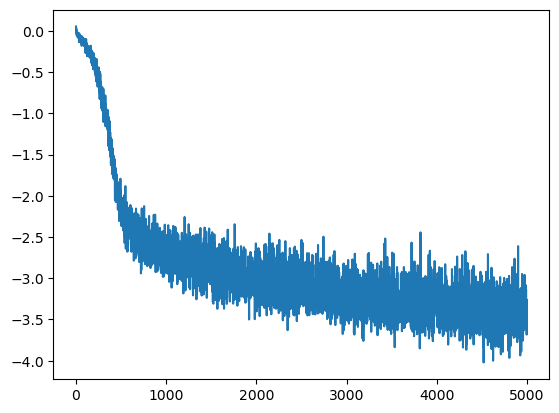

In [9]:
plt.plot(losses)

In [10]:
@functools.partial(jax.jit, static_argnames=("num_steps",))
def langevin_sampling(
    params: chex.ArrayTree,
    key: chex.PRNGKey,
    step_size: float,
    initial_samples: jax.Array,
    num_steps: int,
) -> jax.Array:

    def scan_fn(carry, _):
        states, key = carry
        key, sk = jax.random.split(key)
        noise = jax.random.normal(sk, shape=states.shape)
        next_states = states + step_size * model.apply(params, states) + jnp.sqrt(2 * step_size) * noise
        return (next_states, key), None

    states = initial_samples
    (states, _), _ = jax.lax.scan(scan_fn, (states, key), jnp.arange(num_steps))
    return states

(-1.5, 1.5)

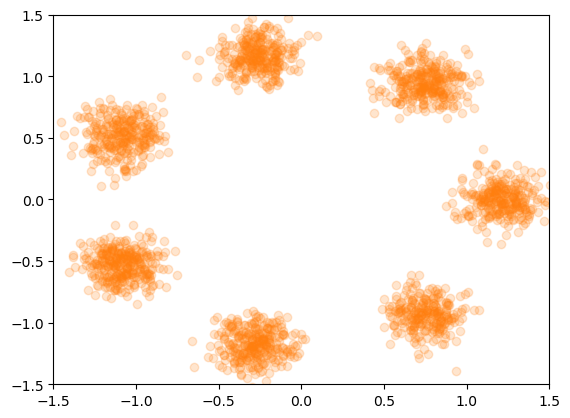

In [13]:
samples = langevin_sampling(
    params,
    next(prng_seq),
    5e-3,
    2 * jax.random.normal(next(prng_seq), shape=(2000, 2)),
    1000)
plt.plot(samples[:, 0], samples[:, 1], '.')
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

In [16]:
from jax.scipy.special import logsumexp

def log_likelihood(params, model, data, num_samples=10000):
    # Compute energies for the given data
    energies = model.apply(params, data)

    # Estimate log Z using samples (here we pretend we have some sampled data)
    sampled_data = jax.random.normal(jax.random.PRNGKey(42), (num_samples,) + data.shape[1:])
    sampled_energies = model.apply(params, sampled_data)
    log_Z = logsumexp(-sampled_energies) - jnp.log(num_samples)

    # Calculate log likelihood
    log_likelihoods = -energies.squeeze() - log_Z
    return jnp.mean(log_likelihoods)

In [17]:
avg_log_likelihood = log_likelihood(params, model, X)


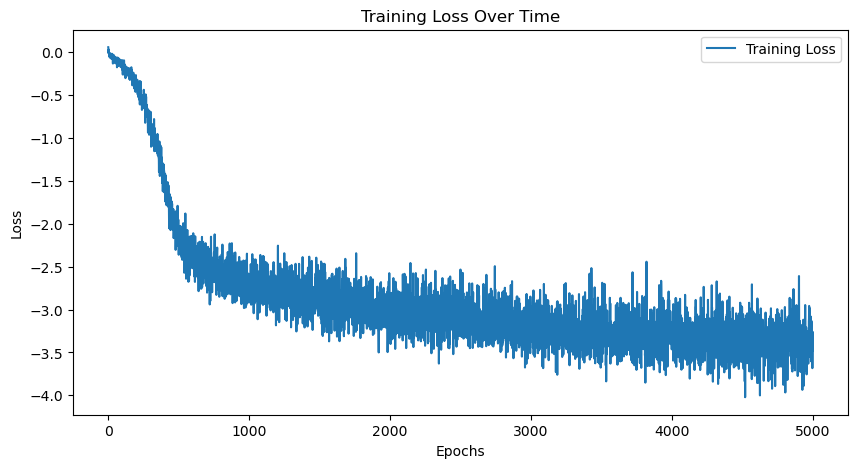

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()